In [59]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import allantools as at
from scipy.stats import norm
import os
import re
from math import ceil, floor, log10, sqrt, trunc, modf
import sympy as sy
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
import allantools
from typing import NamedTuple
from datetime import datetime, timedelta
import copy
from scipy import optimize, integrate
from ftplib import FTP, error_perm
from io import BytesIO
from allantools import oadev

In [60]:
save_dir1 = '/eos/user/e/elsweene/SWAN_projects/'

In [316]:
most_recent_data = pd.read_csv(save_dir1 +'recent_data_30_days_04_08.csv')

In [62]:
most_recent_data

,Unnamed: 0,Bin Start UTC,Bin Start MJD Days,Bin Start Seconds,Bin End MJD Days,Bin End Seconds,f0,uA (f0),uB (f0),Freq Diff (LD-HD),...,uA (LD),Mean HD Signal (Vs),uA (HD Sig),Mean LD Signal (Vs),uA (LD Sig),No. of HD Points,No. of LD Points,HD Deadtimes,LD Deadtimes,timestamp
0,159,2023-07-13T15:00:00Z,60138,54000,60138,57599,1.061354e-14,3.623461e-15,2.174000e-16,4.599683e-15,...,2.987106e-15,0.050148,0.000118,0.006902,0.000006,90,516,"[(54000, 55614), (55628, 55729), (55742, 55844...","[(54000, 55631), (55725, 55746), (55840, 55861...",60138.625000
1,160,2023-07-13T16:00:00Z,60138,57600,60138,61199,3.922828e-15,2.838484e-15,2.160000e-16,-4.422856e-15,...,2.344022e-15,0.047751,0.000072,0.006556,0.000004,155,941,"[(57600, 57683), (57696, 57797), (57810, 57912...","[(57600, 57604), (57679, 57699), (57794, 57814...",60138.666667
2,161,2023-07-13T17:00:00Z,60138,61200,60138,64799,9.517143e-15,2.653736e-15,2.165000e-16,4.492345e-15,...,2.209572e-15,0.049010,0.000075,0.006732,0.000004,155,942,"[(61200, 61244), (61257, 61359), (61372, 61474...","[(61200, 61201), (61240, 61260), (61355, 61375...",60138.708333
3,162,2023-07-13T18:00:00Z,60138,64800,60138,68399,4.358167e-15,2.661605e-15,2.337000e-16,-6.573586e-15,...,2.210266e-15,0.049085,0.000117,0.006723,0.000007,160,937,"[(64800, 64806), (64819, 64921), (64934, 65036...","[(64800, 64802), (64802, 64822), (64917, 64937...",60138.750000
4,163,2023-07-13T19:00:00Z,60138,68400,60138,71999,7.239959e-15,2.826906e-15,2.051000e-16,-2.467660e-15,...,2.361264e-15,0.048900,0.000203,0.006687,0.000011,155,941,"[(68400, 68482), (68496, 68597), (68610, 68712...","[(68400, 68404), (68479, 68499), (68593, 68614...",60138.791667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
665,824,2023-08-10T08:00:00Z,60166,28800,60166,32399,9.382734e-15,2.902931e-15,3.004000e-16,1.216864e-14,...,2.418309e-15,0.049736,0.000051,0.006820,0.000003,158,939,"[(28800, 28801), (28807, 28909), (28922, 29024...","[(28800, 28811), (28905, 28925), (29020, 29040...",60166.333333
666,825,2023-08-10T09:00:00Z,60166,32400,60166,35999,7.484013e-15,2.897957e-15,2.006000e-16,8.473832e-16,...,2.410599e-15,0.049863,0.000064,0.006832,0.000004,155,942,"[(32400, 32471), (32484, 32586), (32599, 32700...","[(32400, 32402), (32467, 32487), (32582, 32602...",60166.375000
667,826,2023-08-10T10:00:00Z,60166,36000,60166,39599,7.342012e-15,2.800431e-15,2.004000e-16,6.719236e-16,...,2.336211e-15,0.050004,0.000115,0.006909,0.000007,157,939,"[(36000, 36032), (36045, 36147), (36160, 36262...","[(36000, 36002), (36028, 36049), (36143, 36164...",60166.416667
668,827,2023-08-10T11:00:00Z,60166,39600,60166,43199,3.967546e-15,2.708395e-15,2.104000e-16,-3.517938e-15,...,2.245660e-15,0.051198,0.000072,0.007073,0.000004,158,939,"[(39600, 39601), (39607, 39709), (39722, 39824...","[(39600, 39610), (39705, 39725), (39820, 39840...",60166.458333


In [63]:
def mjd_now():
    """
    Convert a date to Modified Julian Day.

    Algorithm sourced from 'Practical Astronomy with your Calculator or Spreadsheet',
        4th ed., Duffet-Smith and Zwart, 2011.

    Parameters
    ----------
    year : int
        Year as integer. Years preceding 1 A.D. should be 0 or negative.
        The year before 1 A.D. is 0, 10 B.C. is year -9.

    month : int
        Month as integer, Jan = 1, Feb. = 2, etc.

    day : float
        Day, may contain fractional part.

    Returns
    -------
    mjd : float
        Modified Julian Day

    """
   
    year, month, day, h, m, s = datetime.now().year, datetime.now().month, datetime.now().day, datetime.now().hour, datetime.now().minute, datetime.now().second,
   
    if month == 1 or month == 2:  # months rescaled so february is last month of the year because 28 days
        yearp = year - 1
        monthp = month + 12
    else:
        yearp = year
        monthp = month

    # this checks where we are in relation to October 15, 1582, the beginning
    # of the Gregorian calendar.
    if ((year < 1582) or
            (year == 1582 and month < 10) or
            (year == 1582 and month == 10 and day < 15)):
        # before start of Gregorian calendar
        print('Time must be later than October 1582')
        raise SystemExit

    # after start of Gregorian calendar
    a = trunc(yearp / 100.)  # discount leap years falling on a multiple of 100
    b = 2 - a + trunc(a / 4.)  # recount leap years falling on a multiple of 400

    c = trunc(365.25 * yearp)

    d = trunc(30.6001 * (monthp + 1))

    jd = b + c + d + day + 1720994.5  # Integer is julian day for 2 B.C. Oct 30
    jd += h/24 + m/1440 + s/86400

    return jd - 2400000.5

In [324]:
## Assign arrays to columns to allow indexing

Time_CSF_array = np.array(most_recent_data['timestamp'])    
F0_CSF_array = np.array(most_recent_data['f0']) 

In [325]:
len(F0_CSF_array)

768

In [66]:
## Define funcction to fit line 

def fit_line(Array_of_interest1,Array_of_interest2,index,numberhrs):
    
    m,b = np.polyfit(Array_of_interest1[index:index+numberhrs],-1*Array_of_interest2[index:index +numberhrs], 1)
    
    return m,b

In [67]:
## Define function with loop to correct data by desired number of hours - in this case need steps to steer GPS data

def CSF_Correction(loop_range,number_hours):

    i = 0
    F0_CSF_array1= np.array(most_recent_data['f0'])
    steps = []                                   # store steps to steer GPS data later

    for i in loop_range:

        m,b = fit_line(Time_CSF_array,-1*F0_CSF_array1,i,number_hours)     ## fit to section of data 
        step_f = m*(Time_CSF_array[i+(number_hours-1)]) + b                ## calculate step using fit (removes outliers)

        steps.append(step_f)


        F0_CSF_array1[i:] -= step_f             # add step to all frequencies from this index on
        
        
    return F0_CSF_array1,steps

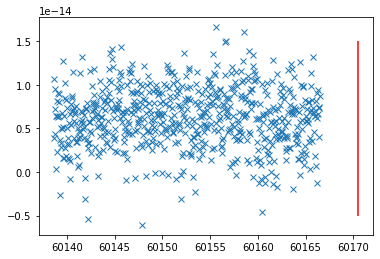

In [68]:
plt.plot(most_recent_data['timestamp'],most_recent_data['f0'],'x')
plt.vlines(mjd_now(),-0.5e-14,1.5e-14,color='r')

In [69]:
read_steer_history = np.loadtxt(save_dir1+"CSF_steer_history.txt")

/tmp/ipykernel_550/2266984224.py:1: UserWarning: loadtxt: Empty input file: "/eos/user/e/elsweene/SWAN_projects/CSF_steer_history.txt"
  read_steer_history = np.loadtxt(save_dir1+"CSF_steer_history.txt")


In [70]:
read_steer_history1 = read_steer_history.tolist()

In [71]:
read_steer_history1

IndexError: list index out of range

In [14]:
len(read_steer_history1)

670

In [15]:
np.arange(0,len(read_steer_history1),1)

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

5.3378219615480986e-15

In [40]:
shifted_f0 = []
times = []

for i in np.arange(0,len(read_steer_history1)-1,1) :
    
    MJD1 = read_steer_history[i][0]
    MJD2 = read_steer_history[i+1][0]
    #print(MJD1,MJD2)
    
    first_cut = most_recent_data[(most_recent_data['timestamp'])>MJD1]
    data_in_MJD1_MJD2_range = first_cut[(first_cut['timestamp'])<MJD2]
    #print((data_in_MJD1_MJD2_range))
    f0_range = (np.array(data_in_MJD1_MJD2_range['f0']))
    
    shifted_array = f0_range - read_steer_history1[i][1]
    shifted_f0.extend(shifted_array)
    
    time_cut = np.array(data_in_MJD1_MJD2_range['timestamp'])
    times.extend(time_cut)
    
    #print(shifted_f0)
    #print(times)

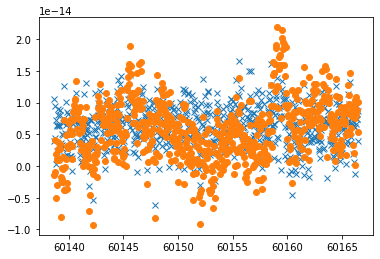

In [41]:
plt.plot(most_recent_data['timestamp'],most_recent_data['f0'],'x')
plt.plot((times),shifted_f0,'o')

In [18]:
shifted_32_hours, steps = CSF_Correction(np.arange(0,635,1),32)

In [243]:
#steps

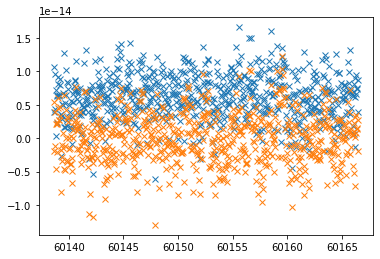

In [19]:
plt.plot(most_recent_data['timestamp'],most_recent_data['f0'],'x')
plt.plot(most_recent_data['timestamp'],shifted_32_hours,'x')

In [72]:
list_times_32_hrs = [most_recent_data['timestamp'][0]]

for i in np.arange(0,669,1) : 
    
    new_time = list_times_32_hrs[i]+32/24
    list_times_32_hrs.append(new_time)

In [245]:
len(steps)

635

In [247]:
for i in np.arange(0,635,1) :

    with open(save_dir1+"CSF_steer_history.txt", "a") as file:
         
        file.write(str(list_times_32_hrs[i]))
        file.write('    ')
        file.write(str(steps[i])+'\n')   

In [248]:
read_steer_history2 = np.loadtxt(save_dir1+"CSF_steer_history.txt")

In [249]:
len(read_steer_history2)

635

In [77]:
(most_recent_data['timestamp'])

0      60138.625000
1      60138.666667
2      60138.708333
3      60138.750000
4      60138.791667
           ...     
665    60166.333333
666    60166.375000
667    60166.416667
668    60166.458333
669    60166.500000
Name: timestamp, Length: 670, dtype: float64

In [150]:
#steps

In [163]:
steers = []

for i in np.arange(1,len(steps),1) :
    
    new_steer = np.sum([(steps[0:i])])
    #print(steps[0:i])
    
    steers.append(new_steer)

In [157]:
#steers

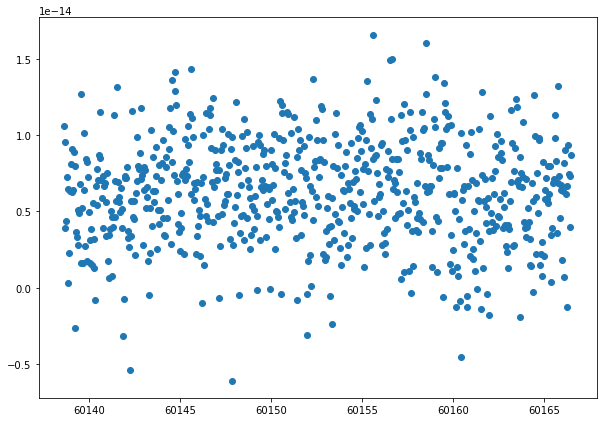

In [268]:
plt.figure(figsize=(10,7))

plt.plot(most_recent_data['timestamp'],most_recent_data['f0'],'o')

In [164]:
for i in np.arange(0,634,1) :

    with open(save_dir1+"CSF_steer_history1.txt", "a") as file:
         
        file.write(str(most_recent_data['ti'][i]))
        file.write('    ')
        file.write(str(steers[i])+'\n')   

In [208]:
read_steer_history3 = np.loadtxt(save_dir1+"CSF_steer_history1.txt")

In [209]:
#list_times_32_hrs

In [204]:
most_recent_data['timestamp']

0      60138.625000
1      60138.666667
2      60138.708333
3      60138.750000
4      60138.791667
           ...     
665    60166.333333
666    60166.375000
667    60166.416667
668    60166.458333
669    60166.500000
Name: timestamp, Length: 670, dtype: float64

In [261]:
shifted_f0 = []
times = []

for i in np.arange(0,633,1) :
    
#     if i == 633 :
        
#         MJD1 = read_steer_history2[i,0]
#         print(MJD1)
        
#         end_cut = most_recent_data[(most_recent_data['timestamp'])>MJD1]
#         #print(end_cut)

        

#    elif i!= 633:
        
    MJD1 = read_steer_history3[i,0]
    MJD2 = read_steer_history3[i+1,0]
    #print(MJD1,MJD2)

    first_cut = most_recent_data[(most_recent_data['timestamp'])>MJD1]
    data_in_MJD1_MJD2_range = first_cut[(first_cut['timestamp'])<MJD2]
    #print((data_in_MJD1_MJD2_range))
    f0_range = (np.array(data_in_MJD1_MJD2_range['f0']))

    shifted_array = f0_range - read_steer_history3[i,1]
    shifted_f0.extend(shifted_array)

    time_cut = np.array(data_in_MJD1_MJD2_range['timestamp'])
    times.extend(time_cut)     

In [262]:
len(shifted_f0)

668

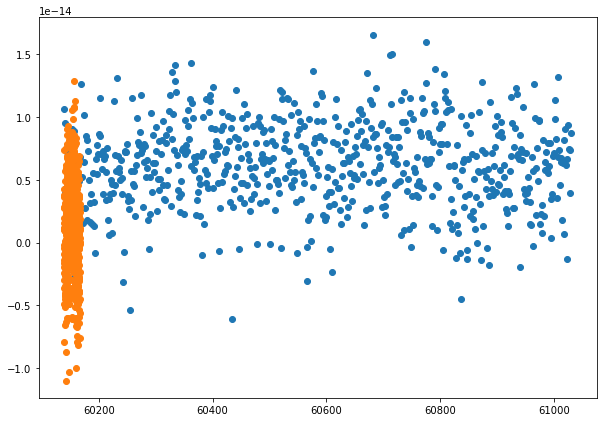

In [265]:
plt.figure(figsize=(10,7))

plt.plot(list_times_32_hrs,most_recent_data['f0'],'o')
plt.plot(times,shifted_f0,'o')
#plt.plot(most_recent_data['timestamp'],shifted_32_hours,'x')

In [239]:
read_steer_history2[-1]

array([6.10306250e+04, 2.76590123e-15])

In [256]:
shifted_f0 = []
times = []
raw_frequencies = np.array(most_recent_data['f0'])

for i in np.arange(0,len(read_steer_history2)-1,1):
    #print(raw_frequencies)
    
    MJD1 = read_steer_history2[i,0]
    MJD2 = read_steer_history2[i+1,0]
    #print(MJD1,MJD2)
    
    first_cut = most_recent_data[(most_recent_data['timestamp'])>MJD1]
    data_in_MJD1_MJD2_range = first_cut[(first_cut['timestamp'])<MJD2]
    f0_range = (np.array(first_cut['f0']))
    
    raw_frequencies[i:] -= read_steer_history2[i,1]
    #print(read_steer_history2[i,1])
    #print(shifted_array)
      
    time_cut = np.array(data_in_MJD1_MJD2_range['timestamp'])
    times.extend(time_cut)

In [251]:
len(shifted_f0)

0

In [252]:
7329 - 669

6660

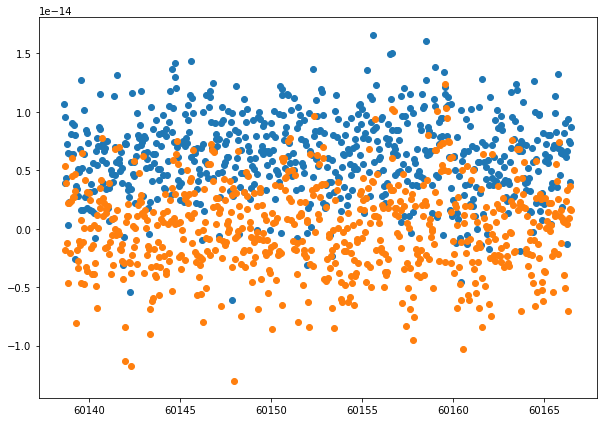

In [260]:
plt.figure(figsize=(10,7))

plt.plot(most_recent_data['timestamp'],most_recent_data['f0'],'o')
plt.plot(times,raw_frequencies[:668],'o')

#plt.plot(most_recent_data['timestamp'],most_recent_data['f0'],'x')
#plt.plot(most_recent_data['timestamp'],shifted_32_hours,'x')

In [321]:
len(most_recent_data['f0'])

768

In [326]:
## Define function with loop to correct data by desired number of hours - in this case need steps to steer GPS data

def CSF_Correction(loop_range,number_hours):

    i = 0
    F0_CSF_array1= np.array(most_recent_data['f0'])
    steps = []                                   # store steps to steer GPS data later
    times = []

    for i in loop_range:

        m,b = fit_line(Time_CSF_array,-1*F0_CSF_array1,i,number_hours)     ## fit to section of data 
        step_f = m*(Time_CSF_array[i+(number_hours-1)]) + b                ## calculate step using fit (removes outliers)

        steps.append(step_f)
        times.append(Time_CSF_array[i])


        F0_CSF_array1[i:] -= step_f             # add step to all frequencies from this index on
        
        
    return F0_CSF_array1,steps,times                                                                                          

In [327]:
shifted_csf, steps1, times1 = CSF_Correction(np.arange(0,735,32),32)

In [328]:
len(steps1)

23

In [329]:
steers1 = []

for i in np.arange(1,len(steps1),1) :
    
    new_steer = np.sum([(steps1[0:i])])
    #print(steps[0:i])
    
    steers1.append(new_steer)

In [330]:
len(steers1)

22

In [331]:
len(times1)

23

In [332]:
for i in np.arange(0,22,1) :

    with open(save_dir1+"CSF_steer_history2.txt", "a") as file:
         
        file.write(str(times1[i]))
        file.write('    ')
        file.write(str(steers1[i])+'\n')   

In [333]:
read_steer_history4 = np.loadtxt(save_dir1+"CSF_steer_history2.txt")

In [334]:
len(read_steer_history4)

22

In [341]:
shifted_f0 = []
times = []

end_times= []
end_shift= []

for i in np.arange(0,len(read_steer_history4),1) :
    
    if i!= len(read_steer_history4)-1:
        
        MJD1 = read_steer_history4[i,0]
        MJD2 = read_steer_history4[i+1,0]
        #print(MJD1,MJD2)

        first_cut = most_recent_data[(most_recent_data['timestamp'])>MJD1]
        data_in_MJD1_MJD2_range = first_cut[(first_cut['timestamp'])<MJD2]
        #print((data_in_MJD1_MJD2_range))
        f0_range = (np.array(data_in_MJD1_MJD2_range['f0']))

        shifted_array = f0_range - read_steer_history4[i,1]
        shifted_f0.extend(shifted_array)

        time_cut = np.array(data_in_MJD1_MJD2_range['timestamp'])
        times.extend(time_cut)    
    
    elif i == len(read_steer_history4)-1:
        
        MJD1 = read_steer_history4[i,0]
        #print(MJD1)
        
        end_cut = most_recent_data[(most_recent_data['timestamp'])>MJD1]
        #print(end_cut)
        f0_end_range = (np.array(end_cut['f0']))
        
        
        shifted_end = f0_end_range - read_steer_history4[-1,1]
        end_shift.extend(shifted_end)        
        
        time = np.array(end_cut['timestamp'])
        end_times.extend(time)    

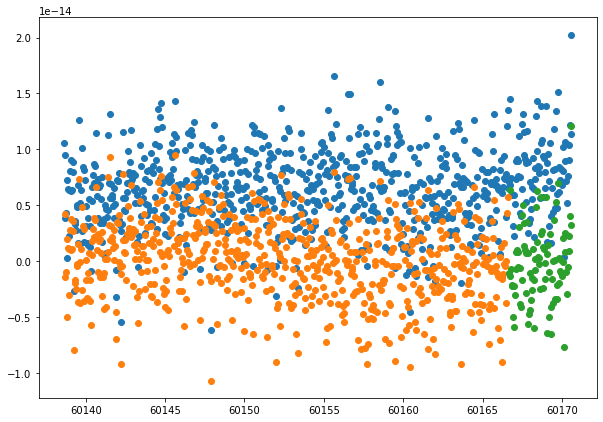

In [342]:
plt.figure(figsize=(10,7))

plt.plot(most_recent_data['timestamp'],most_recent_data['f0'],'o')
plt.plot(times,shifted_f0,'o')
plt.plot(end_times,end_shift,'o')